We perform a time evolution after a global quench, where all spins are initialized in the $\ket{\downarrow}$ state, except for a spin in the center of the lattice, which is initialized in the $\ket{\uparrow}$ state. We evolve in time with the transverse field Ising model at $g=3.5$, $J=1$.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import h5py
import sys
sys.path.append("../../")
from src.runs import global_quench_TEBD
from src.isoTPS.honeycomb import isoTPS

In [3]:
run_parameters = {
    "tps_params": {
        # Dimensions of the lattice
        "Lx": 4,
        "Ly": 4,
        # Maximum bond dimension
        "D_max": 2,
        "D_max_horizontal": 4,
        "chi_factor": 4,
        # Physical bond dimension
        "d": 2,
        # Options for the YB move
        "yb_options" : { 
            "mode" : "svd",
            "disentangle": True,
            "disentangle_options": {
                "mode": "renyi_approx",
                "renyi_alpha": 0.5,
                "method": "trm",
                "N_iters": 10, # 100
            }
        },
        # Options for the TEBD algorithm
        "tebd_options": {
            "mode" : "iterate_polar",
            "N_iters": 10, # 100
        },
        # Options for variational column optimization
        "perform_variational_column_optimization": False,
        "variational_column_optimization_options": {},
        # debug logging
        "debug_logger_options": {
            "log_algorithm_walltimes": True,
            "log_approximate_column_error_yb": True,
            "log_approximate_column_error_tebd": True,
        }
    },
    "model_params": {
        "g": 3.5,
        "J": 1.0
    },
    "lattice": "honeycomb",
    "dt": 0.02,
    # number of TEBD iterations per dtau
    "N_steps": 50,
    "initialize": "product"
}
# Maximum bond dimensions
D_maxs = [2, 4]
# initial state: all spins up, with a spin down in the center of the lattice
Lx, Ly = run_parameters["tps_params"]["Lx"], run_parameters["tps_params"]["Ly"]
x_center, y_center = Lx//2, Ly//2
center_index = (x_center * Ly + y_center)*2
run_parameters["initial_state"] = [np.array([0.0, 1.0]) for _ in range(2*Lx*Ly)]
run_parameters["initial_state"][center_index] = np.array([1.0, 0.0])

In [4]:
# Perform global quench
for D_max in D_maxs:
    print(f"Computing global quench for D_max = {D_max} ...")
    start = time.time()
    run_parameters["tps_params"]["D_max"] = D_max
    run_parameters["tps_params"]["D_max_horizontal"] = D_max**2
    run_parameters["output_folder"] = f"output/global_quench/D_{D_max}"
    global_quench_TEBD.perform_global_quench_run(**run_parameters)
    end = time.time()
    print(f"Took {round(end-start, 3)} seconds.")

Computing global quench for D_max = 2 ...
Took 109.872 seconds.
Computing global quench for D_max = 4 ...
Took 590.38 seconds.


In [5]:
# Compute expectation values
for D_max in D_maxs:
    print(f"Computing expectation values for D_max = {D_max} ...")
    start = time.time()
    output_folder = f"output/global_quench/D_{D_max}"
    global_quench_TEBD.compute_onsesite_expectation_values(run_parameters["N_steps"], output_folder, lattice="honeycomb")
    end = time.time()
    print(f"Took {round(end-start, 3)} seconds.")

Computing expectation values for D_max = 2 ...


/home/benjamin/Documents/Uni/PhD/Projects/YB-isoTPS/test/TFI_honeycomb/../../src/utility/disentangle/renyiAlphaIterate.py:350: RuntimeWarning: overflow encountered in scalar divide
  self.F[i, j] = 1/temp
/home/benjamin/Documents/Uni/PhD/Projects/YB-isoTPS/test/TFI_honeycomb/../../src/utility/disentangle/renyiAlphaIterate.py:375: RuntimeWarning: invalid value encountered in multiply
  dX = self.X@(self.F * (dP*self.S + self.S[:, np.newaxis]*np.conj(dP.T)) + dD) + temp # { D^4 }
/home/benjamin/Documents/Uni/PhD/Projects/YB-isoTPS/test/TFI_honeycomb/../../src/utility/disentangle/renyiAlphaIterate.py:380: RuntimeWarning: invalid value encountered in multiply
  dY = self.Y@(self.F * (self.S[:, np.newaxis]*dP + np.conj(dP.T)*self.S) - dD) + temp # { D^4 }


Took 13.171 seconds.
Computing expectation values for D_max = 4 ...
Took 72.864 seconds.


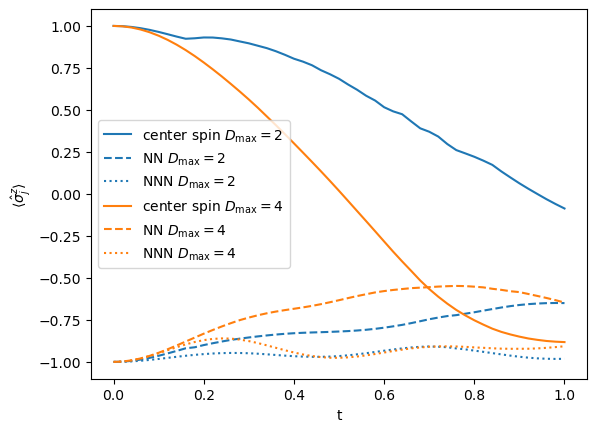

In [6]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ts = np.arange(run_parameters["N_steps"]+1) * run_parameters["dt"]
for i, D_max in enumerate(D_maxs):
    output_filename = f"output/global_quench/D_{D_max}/expectation_values.h5"
    with h5py.File(output_filename) as hf:
        # hf["expectation values"] is an array of shape (N_steps + 1, 3, N_spins), where N_steps is the number of time steps,
        # N_spins is the number of sites and the second index selects the operator, ["sigma_x", "sigma_y", "sigma_z"].
        plt.plot(ts, np.real_if_close(hf["expectation_values"][:, 2, center_index]), ls="-", color=colors[i], label=r"center spin $D_\text{max}="+str(D_max)+r"$")
        plt.plot(ts, np.real_if_close(hf["expectation_values"][:, 2, center_index+1]), ls="--", color=colors[i], label=r"NN $D_\text{max}="+str(D_max)+r"$")
        plt.plot(ts, np.real_if_close(hf["expectation_values"][:, 2, center_index+2]), ls=":", color=colors[i], label=r"NNN $D_\text{max}="+str(D_max)+r"$")
plt.xlabel(r"t")
plt.ylabel(r"$\langle\hat{\sigma}^z_j\rangle$")
plt.legend()
plt.show()

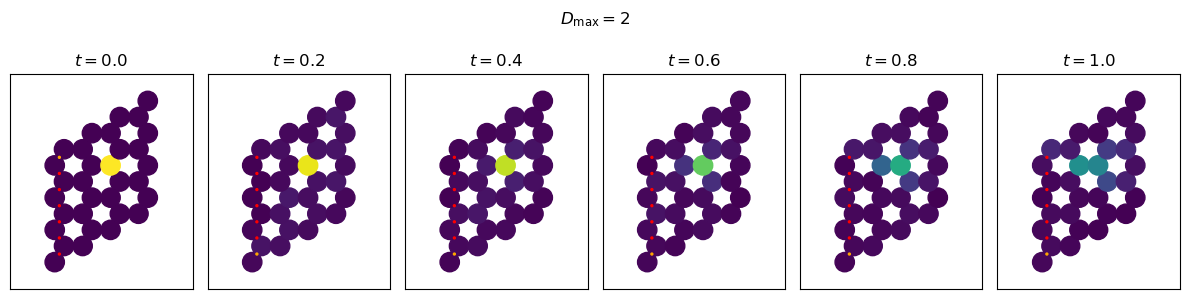

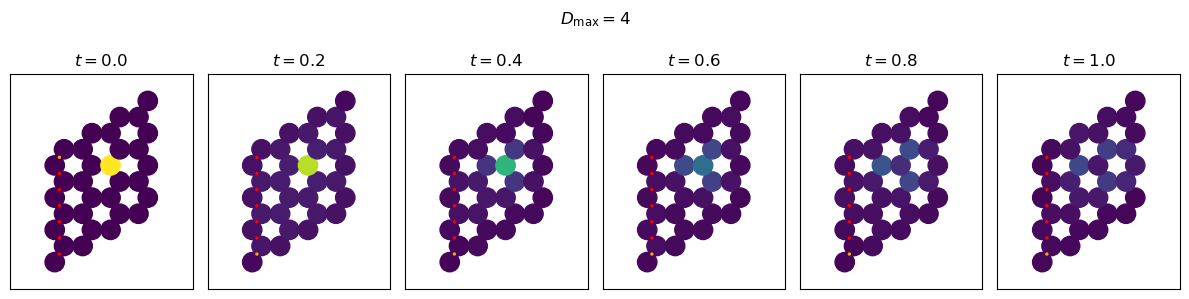

In [7]:
plot_steps = [0, 10, 20, 30, 40, 50]
cmap = plt.colormaps['viridis']
for D_max in D_maxs:
    fig, axarray = plt.subplots(1, len(plot_steps), figsize=(len(plot_steps)*2, 3))
    # Load expectation values
    filename = f"output/global_quench/D_{D_max}/expectation_values.h5"
    with h5py.File(filename) as hf:
        expectation_values = np.real_if_close(hf["expectation_values"][()])
    # Plot expectation values on lattice
    for i, step in enumerate(plot_steps):
        colors_sigma_z = [cmap((sigma_z + 1.0) / 2.0) for sigma_z in expectation_values[step, 2, :]]
        filename = f"output/global_quench/D_{D_max}/tps_{step}.h5"
        tps = isoTPS.isoTPS_Honeycomb.load_from_file(filename)
        tps.plot(T_colors=colors_sigma_z, ax=axarray[i], show_bond_dims=False, T_tensor_scale=10)
        axarray[i].set_title(r"$t = "+str(ts[step])+r"$")
    plt.suptitle(r"$D_\text{max}="+str(D_max)+r"$")
    plt.tight_layout()
    plt.show()